#Lab 2 - Image generation
* Implement a linear or convolutional neural network of two hidden layers.
* Train it on the MNIST dataset.
* Compare the quality of training when using different activation functions (ReLU, GELU, Swish, Softplus is required, the rest are optional). Implement activation functions!
* Plot the accuracy activation functions against epochs.
* Come up with a more effective activation function in this case (+5 points).

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghfranjabour","key":"d6b9250843fc9df2a325c0b59747fc6e"}'}

#Installation and data loading

In [ ]:
!pip install pytorch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
!pip install -q kaggle
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.6 MB/s eta 0:00:00


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d hojjatk/mnist-dataset

 23% 5.00M/22.0M [00:00<00:00, 47.9MB/s]
100% 22.0M/22.0M [00:00<00:00, 135MB/s] 


In [ ]:
!unzip '/content/mnist-dataset.zip' -d 'mnist-dataset'

Archive:  /content/mnist-dataset.zip
  inflating: mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: mnist-dataset/t10k-images.idx3-ubyte  
  inflating: mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: mnist-dataset/t10k-labels.idx1-ubyte  
  inflating: mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: mnist-dataset/train-images.idx3-ubyte  
  inflating: mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: mnist-dataset/train-labels.idx1-ubyte  


#Reading data

In [ ]:
import fastbook
fastbook.setup_book()
from fastai import *
from fastbook import *
import struct

torch.autograd.set_detect_anomaly(True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

Mounted at /content/gdrive
GPU is available and being used


In [ ]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def load_mnist(train_img_path, train_lbl_path, test_img_path, test_lbl_path):
    x_train = read_idx(train_img_path)
    y_train = read_idx(train_lbl_path)
    x_test = read_idx(test_img_path)
    y_test = read_idx(test_lbl_path)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
train_images_path = "/content/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte"
train_labels_path = "/content/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte"
test_images_path = "/content/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_labels_path = "/content/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"

# Load the data
(x_train, y_train), (x_test, y_test) = load_mnist(train_images_path, train_labels_path, test_images_path, test_labels_path)

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class ImageDataset(Dataset):
    def __init__(self, x_array, y_array, transform):
        print("Reading Image Dataset...")
        # self.dataset_root = dataset_root
        # self.classes = sorted([name for name in os.listdir(self.dataset_root)
        #                        if os.path.isdir(f'{self.dataset_root}/{name}')])
        self.classes = np.unique(y_train)
        self.label_to_idx = {val: idx for idx, val in enumerate(self.classes)}
        self.x_array = x_array
        print("Reading dataset file paths...")
        self.img_labels = pd.DataFrame(y_array) #pd.read_csv(f'/content/{csv_filename}', delimiter=',')
        self.transform = transform
        print("Image Dataset instance created!")

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        label = self.img_labels.iloc[index, 0]
        # img_name = self.img_labels.iloc[index, 1]
        #img_path = img_name #f'{self.dataset_root}/{label}/{img_name}'
        image =Image.fromarray(self.x_array[index]).convert('RGB') # Image.open(img_path).convert('RGB')

        image_tensor = self.transform(image)
        image.close()
        return image_tensor, self.label_to_idx[label]

In [ ]:
from torchvision import transforms as T
img_sz = 28

normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_data_transforms = T.Compose([
        T.Resize(28),
        T.CenterCrop(img_sz),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        normalize
    ])
test_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])

In [ ]:
len(x_test)

10000

In [ ]:
image_datasets = dict()
image_datasets['train'] = ImageDataset(x_train[:3000],
                                       y_train[:3000],
                                       transform=train_data_transforms)
image_datasets['test'] = ImageDataset(x_test[:500],
                                       y_test[:500],
                                       transform=test_data_transforms)

Reading Image Dataset...
Reading dataset file paths...
Image Dataset instance created!
Reading Image Dataset...
Reading dataset file paths...
Image Dataset instance created!


##Dataloader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 20
num_workers = 2
num_classes = len(np.unique(y_train))
dataloaders = dict()
dataloaders['train'] = DataLoader(image_datasets['train'],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True)
dataloaders['test'] = DataLoader(image_datasets['test'],
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers,
                                  pin_memory=True)

In [ ]:
from google.colab.patches import cv2_imshow
print(y_train[:3])
cv2_imshow(x_train[0])
cv2_imshow(x_train[1])
cv2_imshow(x_train[2])

[5 0 4]


#Defining model

In [ ]:
from torchsummary import summary

class Net(nn.Module):
    def __init__(self, num_classes, activation_fn = nn.ReLU):
        self.activation_fn = activation_fn
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5),
            nn.Dropout(0.3),
            activation_fn(),
        ).to(device)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1728, num_classes)
        ).to(device)

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

model = Net(num_classes, nn.ReLU).to(device)
summary(model, (3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 24, 24]             228
           Dropout-2            [-1, 3, 24, 24]               0
              ReLU-3            [-1, 3, 24, 24]               0
           Flatten-4                 [-1, 1728]               0
            Linear-5                   [-1, 10]          17,290
Total params: 17,518
Trainable params: 17,518
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.07
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


#Training the neural network classifier

##Needed functions

In [ ]:
from sklearn import metrics

def run_epoch(phase, dataloader):
  if phase == 'train':
      model.train()
  else:
      model.eval()

  running_loss = 0.0
  running_corrects = 0
  y_test = []
  y_pred = []
  all_elems_count = 0
  cur_tqdm = tqdm(dataloader)
  for inputs, labels in cur_tqdm:
      bz = inputs.shape[0]
      all_elems_count += bz

      inputs = inputs.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      _, preds = torch.max(outputs, 1)
      y_test.extend(labels.detach().cpu().numpy())
      y_pred.extend(preds.detach().cpu().numpy())
      running_loss += loss.item() * bz
      corrects_cnt = torch.sum(preds == labels.detach())
      running_corrects += corrects_cnt
      show_dict = {'Loss': f'{loss.item():.6f}',
                    'Corrects': f'{corrects_cnt.item()}/{bz}',
                    'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
      cur_tqdm.set_postfix(show_dict)

  conf_matrix = metrics.confusion_matrix(y_test, y_pred)

  print("Calculating metrics...")
  f05_macro = metrics.fbeta_score(y_test, y_pred, average="macro", beta=0.5)
  f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
  epoch_loss = running_loss / all_elems_count
  epoch_acc = running_corrects.float().item() / all_elems_count
  return epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix

def test_epoch(dataloader):
    with torch.inference_mode():
      return run_epoch('test', dataloader)

def train_epoch(dataloader):
    return run_epoch('train', dataloader)

In [ ]:
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

def train_model(dataloaders, num_epochs=5):
  print(f"Training model with params:")
  print(f"Optim: {optimizer}")
  print(f"Criterion: {criterion}")

  phases = ['train', 'test']
  for phase in dataloaders:
      if phase not in phases:
          phases.append(phase)

  saved_epoch_losses = {phase: [] for phase in phases}
  saved_epoch_accuracies = {phase: [] for phase in phases}
  saved_epoch_f1_macros = {phase: [] for phase in phases}

  for epoch in range(1, num_epochs + 1):
      start_time = time.time()

      print("=" * 100)
      print(f'Epoch {epoch}/{num_epochs}')
      print('-' * 10)

      for phase in phases:
          print("--- Cur phase:", phase)
          epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = \
              train_epoch(dataloaders[phase]) if phase == 'train' \
                  else test_epoch(dataloaders[phase])
          saved_epoch_losses[phase].append(epoch_loss)
          saved_epoch_accuracies[phase].append(epoch_acc)
          saved_epoch_f1_macros[phase].append(f1_macro)
          print(f'{phase} loss: {epoch_loss:.6f}, '
                f'acc: {epoch_acc:.6f}, '
                f'f05_macro: {f05_macro:.6f}, '
                f'f1_macro: {f1_macro:.6f}')
          print("Confusion matrix:")
          print(conf_matrix)

      model.eval()
      if epoch > 1:
        plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
        plt.plot(range(1, epoch + 1), saved_epoch_losses['test'], label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel(criterion.__class__.__name__)
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/loss_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

        plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
        plt.plot(range(1, epoch + 1), saved_epoch_accuracies['test'], label='Test Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc="upper left")
        plt.savefig(f'{log_folder}/acc_graph_epoch{epoch + 1}.png')
        plt.show()
        plt.close('all')

      end_time = time.time()
      epoch_time = end_time - start_time
      print("-" * 10)
      print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

  print("*** Training Completed ***")

  return saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros

##Defining avtivation functions

###ReLU

In [ ]:
class ReLU_imp(torch.nn.Module):
    def __init__(self):
        super(ReLU_imp, self).__init__()
        return
    def forward(self, x):
        return torch.max(tensor(0), x)

###Tanh

In [ ]:
class Tanh_imp(torch.nn.Module):
  def __init__(self):
      super(Tanh_imp, self).__init__()
      return
  def forward(self, x):
      return torch.tanh(x)

###GELU

In [ ]:
class GELU_imp(torch.nn.Module):
  def __init__(self):
      super(GELU_imp, self).__init__()
      return
  def forward(self, x):
      return 0.5 * x * ( 1 + torch.tanh( (2/torch.pi)**0.5 * (x + 0.044715 * x**3 ) ))

###Swish

In [ ]:
class Swish_imp(torch.nn.Module):
  def __init__(self):
      super(Swish_imp, self).__init__()
      return
  def forward(self, x):
      return x * torch.sin(x)

###SoftPlus

In [ ]:
class SoftPlus_imp(torch.nn.Module):
  def __init__(self):
      super(SoftPlus_imp, self).__init__()
      return
  def forward(self, x):
      return torch.log(1 + torch.exp(x))

##Training


Training model with  ReLU  Activation function:
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 43.18it/s, Loss=1.304038, Corrects=13/20, Accuracy=65.000%]


Calculating metrics...
train loss: 0.946789, acc: 0.693667, f05_macro: 0.684266, f1_macro: 0.683798
Confusion matrix:
[[246   1   2   7   1  12  11   1   3   1]
 [  0 285  15   2   0   0   6   1  29   1]
 [ 12   7 211   8  10   9  14   5  17   6]
 [ 14   7  14 154   0  41   6   3  45  11]
 [  5   3  14   2 245   0  12   1  10  33]
 [ 25   6  12  54   8 106  12  14  36   1]
 [  8   7  24   5   9   8 239   0   3   3]
 [ 12   7   7   1  10   2   2 255  10  23]
 [  1  21  16  30   2  29   2   1 150   9]
 [  8   6   3   6  15   4   2  32  21 190]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 61.49it/s, Loss=0.781906, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.685686, acc: 0.788000, f05_macro: 0.778103, f1_macro: 0.774408
Confusion matrix:
[[40  0  0  0  0  2  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  2 37  6  0  3  2  3  1  0]
 [ 1  0  0 34  0  6  0  0  2  2]
 [ 1  0  0  0 50  0  2  0  0  2]
 [ 1  0  2 18  1 19  1  6  2  0]
 [ 2  0  1  0  1  2 37  0  0  0]
 [ 0  1  0  0  2  1  0 40  0  5]
 [ 0  1  1  4  0  5  1  4 22  2]
 [ 0  0  0  0  1  2  0  2  1 48]]
----------
Epoch Time: 0:03
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:02<00:00, 57.53it/s, Loss=0.224798, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 0.524322, acc: 0.830667, f05_macro: 0.825412, f1_macro: 0.825174
Confusion matrix:
[[268   0   1   3   3   3   4   0   1   2]
 [  0 327   1   3   0   1   1   0   6   0]
 [  1   4 238  18   5   8  13   4   7   1]
 [  5   2  13 207   0  39   3   3  17   6]
 [  5   2   2   0 289   0   8   3   2  14]
 [  6   2   7  57   2 168   6  11  13   2]
 [  6   6  12   2   5   3 270   0   1   1]
 [  3   5   6   1  10   0   0 282   4  18]
 [  0  10   4  18   2  16   2   3 199   7]
 [  4   0   2   6  13   1   0  15   2 244]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 53.46it/s, Loss=0.642031, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.597125, acc: 0.816000, f05_macro: 0.806380, f1_macro: 0.804503
Confusion matrix:
[[41  0  0  0  0  1  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 45  2  1  3  0  3  1  0]
 [ 0  0  2 22  0 16  1  1  2  1]
 [ 0  0  0  0 50  0  2  0  0  3]
 [ 1  0  2  9  0 28  2  6  2  0]
 [ 2  0  2  0  1  2 36  0  0  0]
 [ 0  0  1  0  1  1  0 44  0  2]
 [ 0  1  1  3  1  1  1  4 27  1]
 [ 0  0  0  0  1  2  0  2  1 48]]


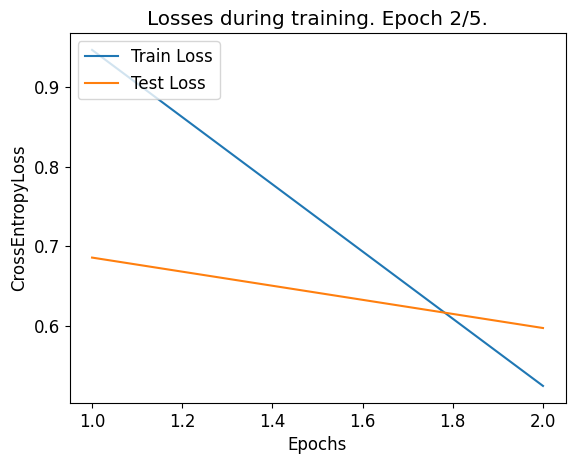

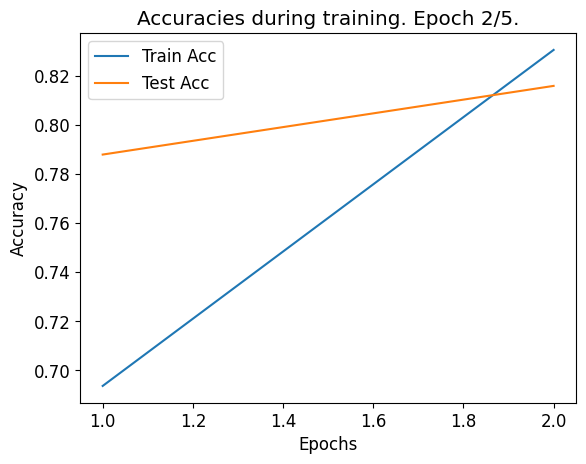

----------
Epoch Time: 0:03
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 41.80it/s, Loss=0.335398, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 0.452586, acc: 0.850333, f05_macro: 0.845398, f1_macro: 0.845552
Confusion matrix:
[[266   0   1   4   2   6   4   1   0   1]
 [  0 330   1   1   0   2   0   1   4   0]
 [  3   2 244  17   3   3  16   3   8   0]
 [  2   3  12 206   0  44   3   5  18   2]
 [  1   2   2   0 298   1   6   1   2  12]
 [  2   1   8  54   2 180   6   6  12   3]
 [  2   3  14   0   1   4 280   0   2   0]
 [  3   1   6   0   6   2   0 287   2  22]
 [  0   6   4  10   1  14   1   2 216   7]
 [  4   0   0   3   9   3   0  20   4 244]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 39.82it/s, Loss=0.651632, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
test loss: 0.512684, acc: 0.850000, f05_macro: 0.844881, f1_macro: 0.841883
Confusion matrix:
[[40  0  0  0  0  2  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 47  3  0  1  0  3  1  0]
 [ 0  0  1 33  0  9  0  0  0  2]
 [ 0  0  0  0 53  0  2  0  0  0]
 [ 1  0  2 11  0 29  1  4  2  0]
 [ 2  0  1  0  1  2 37  0  0  0]
 [ 0  0  0  0  1  1  0 44  0  3]
 [ 0  0  1  4  1  2  1  3 27  1]
 [ 0  0  0  0  1  3  0  2  0 48]]


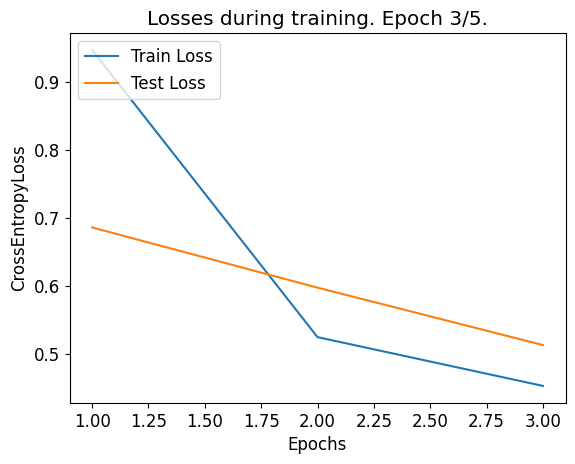

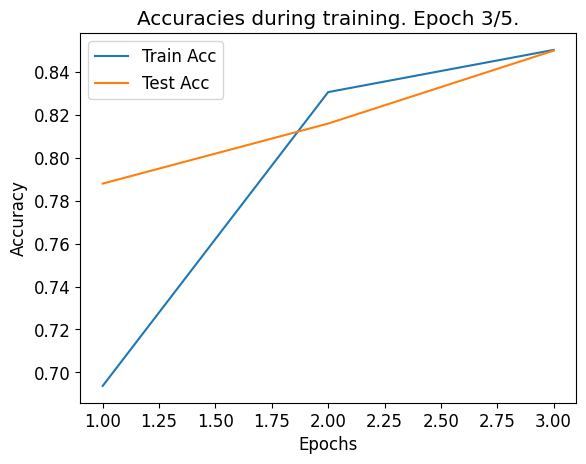

----------
Epoch Time: 0:05
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 37.30it/s, Loss=0.533845, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 0.402834, acc: 0.867333, f05_macro: 0.862456, f1_macro: 0.862442
Confusion matrix:
[[272   0   0   0   1   5   5   2   0   0]
 [  0 330   2   1   3   1   1   0   1   0]
 [  0   5 250  10   3  12   8   4   6   1]
 [  5   3  11 208   0  41   2   5  17   3]
 [  2   1   1   0 309   0   2   1   2   7]
 [  3   0   8  53   0 185   4   4  14   3]
 [  3   1   7   1   2   6 284   0   1   1]
 [  1   3   4   0   6   1   0 297   0  17]
 [  1   6   3  22   0  10   1   2 211   5]
 [  2   0   1   4   4   0   0  17   3 256]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 41.95it/s, Loss=0.657113, Corrects=15/20, Accuracy=75.000%]


Calculating metrics...
test loss: 0.524869, acc: 0.834000, f05_macro: 0.839565, f1_macro: 0.822598
Confusion matrix:
[[39  0  0  0  0  2  1  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 49  1  0  3  0  1  1  0]
 [ 0  0  2 19  0 22  1  0  0  1]
 [ 0  0  0  0 53  0  2  0  0  0]
 [ 0  0  2  1  0 42  1  4  0  0]
 [ 1  0  1  0  0  2 38  1  0  0]
 [ 0  0  4  0  2  2  0 40  0  1]
 [ 0  0  1  1  1  7  2  4 23  1]
 [ 0  0  0  0  2  3  0  2  0 47]]


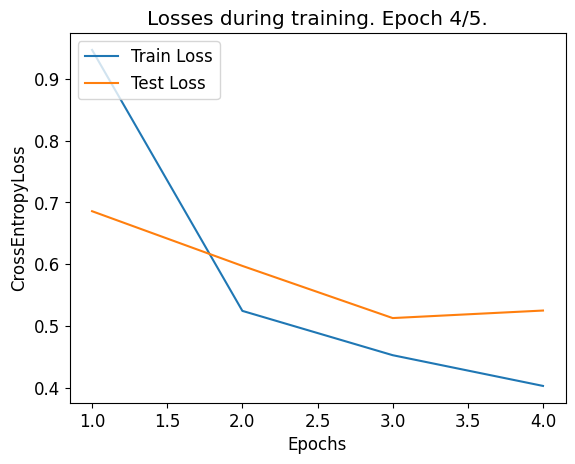

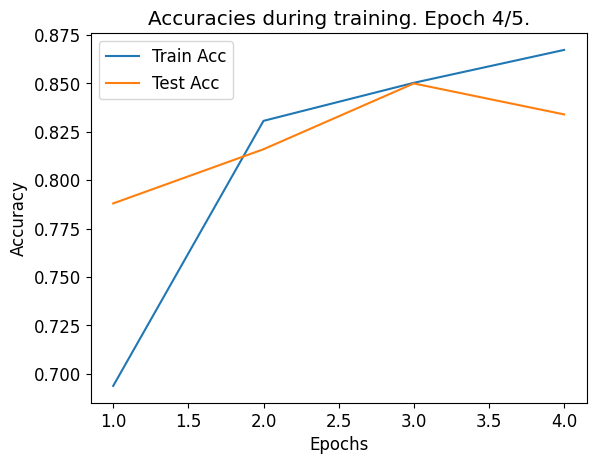

----------
Epoch Time: 0:06
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:05<00:00, 29.58it/s, Loss=0.264704, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
train loss: 0.370810, acc: 0.876000, f05_macro: 0.872410, f1_macro: 0.872152
Confusion matrix:
[[275   0   0   1   0   2   5   1   1   0]
 [  1 326   2   0   1   1   1   1   6   0]
 [  1   4 260  10   3   5   8   3   5   0]
 [  2   3  12 220   0  36   2   2  17   1]
 [  1   1   2   0 308   0   3   1   1   8]
 [  0   0   5  53   1 200   4   4   6   1]
 [  2   3   7   0   2   5 287   0   0   0]
 [  5   1   6   0   5   1   0 294   1  16]
 [  0   6   4  23   0   9   2   2 210   5]
 [  3   1   0   1  10   1   0  18   5 248]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 54.88it/s, Loss=0.562831, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
test loss: 0.527704, acc: 0.834000, f05_macro: 0.824414, f1_macro: 0.823375
Confusion matrix:
[[42  0  0  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 45  2  0  1  1  1  1  3]
 [ 0  0  1 33  0  9  0  0  0  2]
 [ 0  0  0  0 52  0  1  0  0  2]
 [ 0  0  1 14  0 21  2  5  6  1]
 [ 1  0  1  0  0  1 39  1  0  0]
 [ 0  0  1  0  0  1  0 38  0  9]
 [ 0  0  0  2  1  0  1  1 31  4]
 [ 0  0  0  0  1  0  0  1  3 49]]


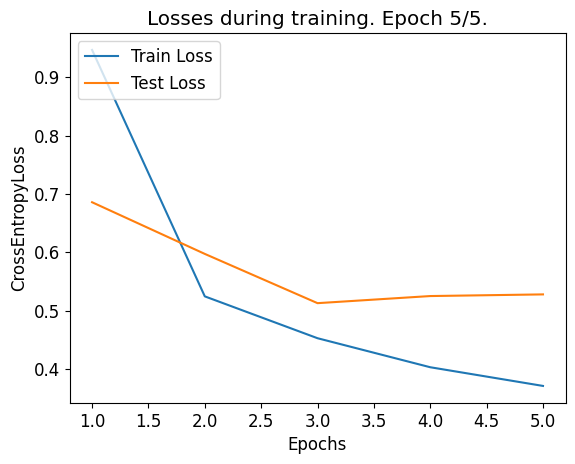

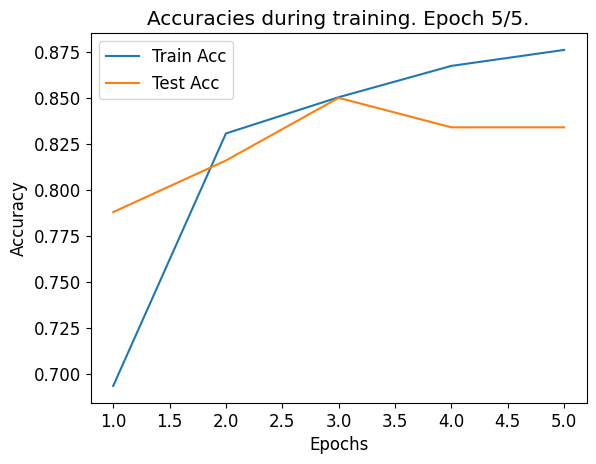

----------
Epoch Time: 0:06
*** Training Completed ***
Training model with  Tanh  Activation function:
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 46.94it/s, Loss=0.251998, Corrects=19/20, Accuracy=95.000%]


Calculating metrics...
train loss: 1.006455, acc: 0.689000, f05_macro: 0.679039, f1_macro: 0.677582
Confusion matrix:
[[228   1   3   5   1  18  13   8   7   1]
 [  2 299   1   0   3   5   5   1  16   7]
 [  3  15 197  10  12   8  26   8  14   6]
 [  9  15  13 171   2  31   8   5  31  10]
 [  1   5   5   1 249   2  13   7   9  33]
 [ 11  22   6  60   9  91  15  23  28   9]
 [  6  13   9   1   8   6 246   1  10   6]
 [  4  14   3   4   6   4   3 247  13  31]
 [  0  28   6  28   9  17   5   2 151  15]
 [  6   8   1   4  28   5   1  35  11 188]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 48.65it/s, Loss=0.814372, Corrects=14/20, Accuracy=70.000%]


Calculating metrics...
test loss: 0.703341, acc: 0.758000, f05_macro: 0.765010, f1_macro: 0.752431
Confusion matrix:
[[36  0  0  0  0  6  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  2 43  3  0  2  0  2  1  2]
 [ 0  2  1 24  0 16  0  0  0  2]
 [ 0  1  1  0 46  1  0  0  0  6]
 [ 0  3  2  8  2 26  1  7  1  0]
 [ 2  0  3  0  4  3 31  0  0  0]
 [ 0  2  0  0  3  3  0 32  0  9]
 [ 0  1  1  6  0  0  1  2 25  4]
 [ 0  1  0  0  1  3  0  0  0 49]]
----------
Epoch Time: 0:03
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 35.02it/s, Loss=0.681984, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
train loss: 0.591590, acc: 0.805000, f05_macro: 0.797388, f1_macro: 0.797518
Confusion matrix:
[[260   0   1   1   1  10   7   5   0   0]
 [  0 327   3   0   0   2   1   0   6   0]
 [  4   5 234  15   9   6  14   4   7   1]
 [  3   8  11 191   0  42   3   6  23   8]
 [  4   3   6   1 272   0   6   2   2  29]
 [  7  11   7  53   7 146   7  16  16   4]
 [  2   3  12   2   5   8 273   0   1   0]
 [  3   3   7   0  11   1   0 282   1  21]
 [  0  12   4  25   0  14   1   3 192  10]
 [  8   1   1   4  19   2   1  11   2 238]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 38.06it/s, Loss=0.729976, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.618930, acc: 0.804000, f05_macro: 0.797379, f1_macro: 0.790317
Confusion matrix:
[[41  0  0  0  0  1  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 46  2  0  0  1  4  1  1]
 [ 1  1  1 36  0  5  0  0  0  1]
 [ 1  1  0  0 49  0  1  0  0  3]
 [ 2  3  2 18  1 15  1  7  1  0]
 [ 2  0  1  0  3  2 35  0  0  0]
 [ 0  2  0  1  2  0  0 43  0  1]
 [ 0  0  2  4  0  0  1  4 28  1]
 [ 0  0  0  5  2  0  0  5  0 42]]


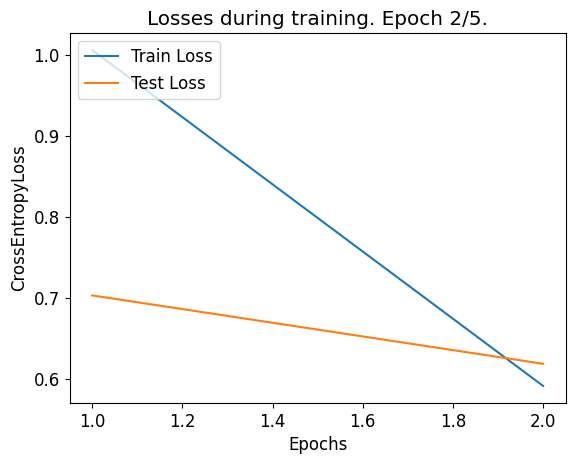

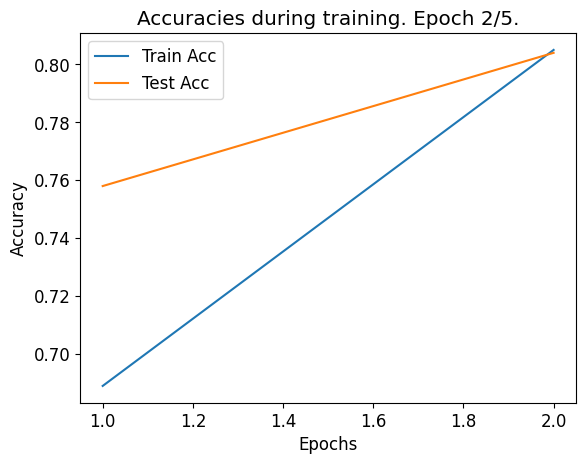

----------
Epoch Time: 0:06
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 34.24it/s, Loss=0.453352, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
train loss: 0.519551, acc: 0.840000, f05_macro: 0.834555, f1_macro: 0.834583
Confusion matrix:
[[267   0   1   1   0   9   4   2   0   1]
 [  0 322   2   1   1   4   0   1   8   0]
 [  5   5 240  11   7   6  13   6   6   0]
 [  4   2  13 213   0  37   5   3  15   3]
 [  2   2   5   0 293   0   6   2   3  12]
 [  7   5   7  53   5 164   7  13  12   1]
 [  3   4   7   2   5   5 279   0   1   0]
 [  4   4   6   0  12   1   0 288   1  13]
 [  1   6   5  15   1  12   1   3 212   5]
 [  5   1   1   4   9   1   0  22   2 242]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 39.02it/s, Loss=0.744674, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
test loss: 0.636771, acc: 0.806000, f05_macro: 0.797483, f1_macro: 0.791766
Confusion matrix:
[[41  0  0  0  0  1  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 43  5  0  0  1  4  1  1]
 [ 0  1  1 33  0  7  0  1  1  1]
 [ 0  1  1  0 48  0  2  0  0  3]
 [ 0  3  1 21  1 13  2  8  1  0]
 [ 1  0  1  0  1  2 37  1  0  0]
 [ 0  0  0  0  2  0  0 44  0  3]
 [ 0  0  2  6  0  0  0  4 27  1]
 [ 0  0  0  2  0  1  0  1  0 50]]


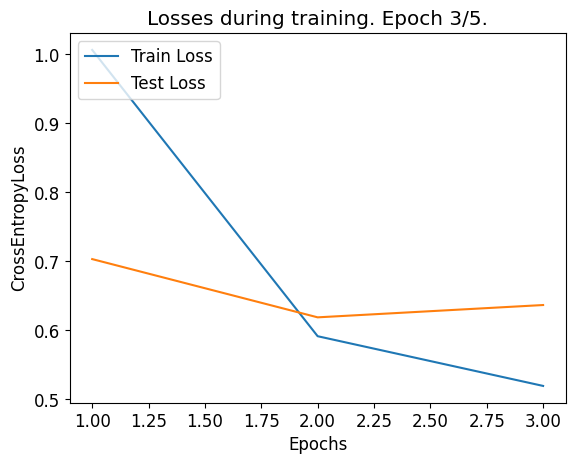

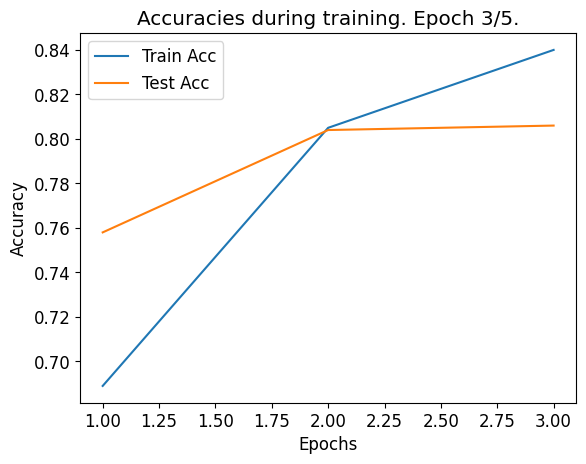

----------
Epoch Time: 0:06
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 43.92it/s, Loss=0.081360, Corrects=20/20, Accuracy=100.000%]


Calculating metrics...
train loss: 0.480924, acc: 0.847667, f05_macro: 0.842945, f1_macro: 0.843014
Confusion matrix:
[[265   0   0   4   1   6   5   3   1   0]
 [  0 324   2   1   1   3   0   2   6   0]
 [  4   3 242  12   8   4  12   6   6   2]
 [  4   2  13 212   0  41   3   3  13   4]
 [  3   4   4   0 288   0   5   2   3  16]
 [  5   5   5  46   5 175   6  12  13   2]
 [  2   3  11   1   4   3 278   0   3   1]
 [  2   3   6   1   9   2   0 291   2  13]
 [  0   5   2  17   1   9   2   2 215   8]
 [  4   0   0   5   6   2   0  16   1 253]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 48.99it/s, Loss=0.537156, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.575487, acc: 0.808000, f05_macro: 0.795152, f1_macro: 0.796033
Confusion matrix:
[[41  0  0  0  0  1  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 44  3  0  1  2  3  1  1]
 [ 0  3  1 25  0 12  2  0  0  2]
 [ 1  0  0  0 51  0  1  0  0  2]
 [ 2  2  2 16  0 18  1  6  3  0]
 [ 2  0  1  0  1  2 37  0  0  0]
 [ 0  1  0  1  2  0  0 43  0  2]
 [ 0  0  2  3  0  0  0  1 32  2]
 [ 0  1  0  1  2  2  0  1  1 46]]


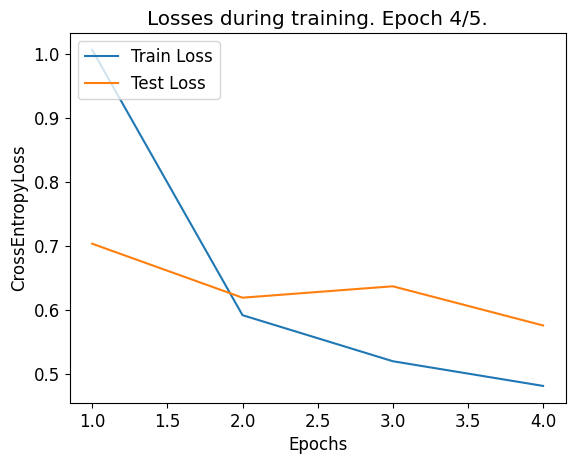

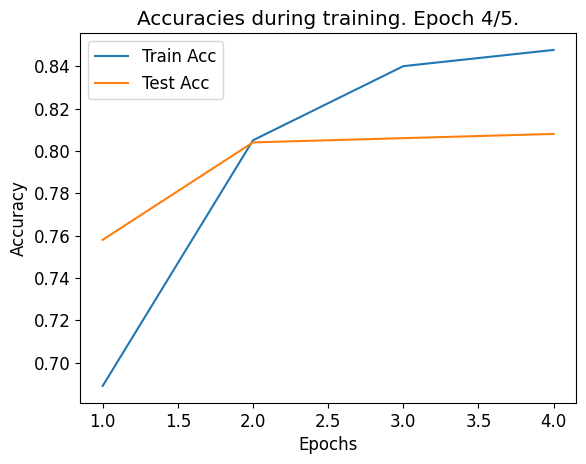

----------
Epoch Time: 0:04
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 43.02it/s, Loss=0.404312, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
train loss: 0.461846, acc: 0.854000, f05_macro: 0.850161, f1_macro: 0.849922
Confusion matrix:
[[267   0   1   4   1   5   3   3   1   0]
 [  0 327   2   0   0   3   0   0   7   0]
 [  2   4 244  16   6   6  10   6   4   1]
 [  4   3  14 218   1  34   3   3  11   4]
 [  1   2   5   0 289   2   4   1   2  19]
 [  4   4   8  46   3 183   6   7  11   2]
 [  3   4  12   0   3   4 279   0   0   1]
 [  3   1   6   1   5   3   1 296   2  11]
 [  0   6   3  20   1   7   2   1 217   4]
 [  5   1   0   5  12   1   1  18   2 242]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 49.60it/s, Loss=0.568137, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
test loss: 0.584693, acc: 0.830000, f05_macro: 0.813516, f1_macro: 0.815104
Confusion matrix:
[[42  0  0  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 46  3  0  0  1  2  1  2]
 [ 1  0  1 27  0  9  1  1  5  0]
 [ 1  0  0  0 50  0  2  0  1  1]
 [ 1  1  2 10  1 19  1  7  8  0]
 [ 2  0  1  0  0  2 38  0  0  0]
 [ 0  0  1  1  1  0  0 42  1  3]
 [ 0  0  1  2  0  0  0  2 35  0]
 [ 0  0  0  0  0  2  0  1  2 49]]


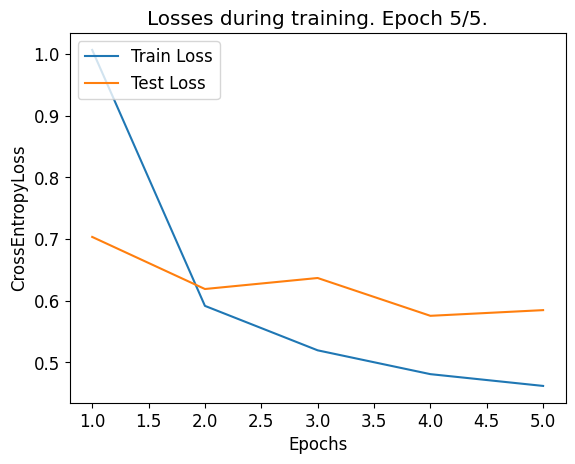

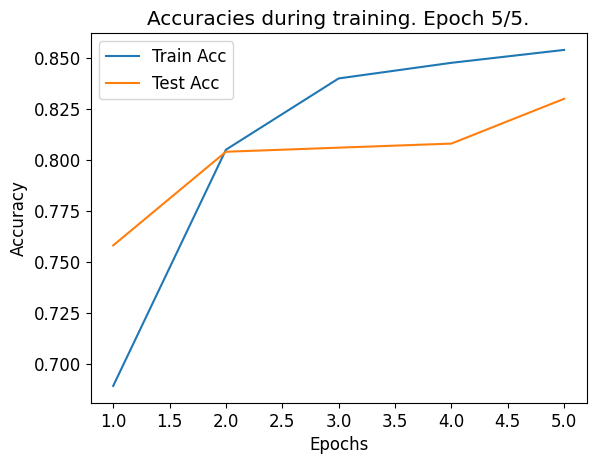

----------
Epoch Time: 0:05
*** Training Completed ***
Training model with  GELU  Activation function:
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:05<00:00, 28.54it/s, Loss=0.317449, Corrects=19/20, Accuracy=95.000%]


Calculating metrics...
train loss: 0.843360, acc: 0.739667, f05_macro: 0.732642, f1_macro: 0.732158
Confusion matrix:
[[244   0   5   8   0  12  12   2   1   1]
 [  1 312   1   2   0   2   1   2  11   7]
 [  3   5 219  22   8   5  11   6  12   8]
 [ 10   5  15 178   1  43   6   2  27   8]
 [  2   5  10   2 258   4   8   4   1  31]
 [ 13   3   7  49   6 143  10  13  20  10]
 [  6  11  24   7   1   9 244   0   2   2]
 [ 10   6   6   3  13   2   0 262   2  25]
 [  0  15  12  43   4  15   3   5 155   9]
 [  6   4   4   8  21   3   5  27   5 204]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 36.30it/s, Loss=0.792807, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
test loss: 0.624282, acc: 0.786000, f05_macro: 0.777494, f1_macro: 0.769135
Confusion matrix:
[[41  0  0  0  0  0  0  1  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  1 46  2  0  0  0  4  1  0]
 [ 1  3  2 26  0 11  0  2  0  0]
 [ 0  1  1  0 52  0  1  0  0  0]
 [ 2  2  2 13  0 19  1  7  4  0]
 [ 2  0  1  0  2  2 36  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  1]
 [ 0  2  1  5  1  0  1  8 21  1]
 [ 0  2  0  1  3  1  0  9  1 37]]
----------
Epoch Time: 0:06
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:06<00:00, 24.09it/s, Loss=0.075710, Corrects=20/20, Accuracy=100.000%]


Calculating metrics...
train loss: 0.464953, acc: 0.852333, f05_macro: 0.848139, f1_macro: 0.848116
Confusion matrix:
[[268   0   1   3   1   3   4   3   1   1]
 [  0 324   1   0   1   2   1   2   8   0]
 [  3   2 245  10   3   6  12   4  12   2]
 [  5   2  13 212   1  40   2   3  17   0]
 [  2   2   3   0 297   0   5   2   3  11]
 [  3   0   4  48   1 194   3   8  10   3]
 [  4   5  10   0   3   7 277   0   0   0]
 [  3   0   4   1   5   3   0 289   1  23]
 [  0  13   4  21   0   8   1   4 206   4]
 [  5   0   0   2   8   3   1  21   2 245]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 37.91it/s, Loss=0.573563, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.497652, acc: 0.826000, f05_macro: 0.811835, f1_macro: 0.807871
Confusion matrix:
[[42  0  0  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 50  0  0  0  0  2  1  1]
 [ 1  1  4 15  0 20  1  1  2  0]
 [ 0  1  0  0 54  0  0  0  0  0]
 [ 0  0  2  3  1 34  1  5  4  0]
 [ 1  0  0  0  2  1 38  0  1  0]
 [ 0  2  3  0  1  0  0 38  0  5]
 [ 0  1  1  1  1  0  1  4 30  1]
 [ 0  1  0  0  3  0  0  2  3 45]]


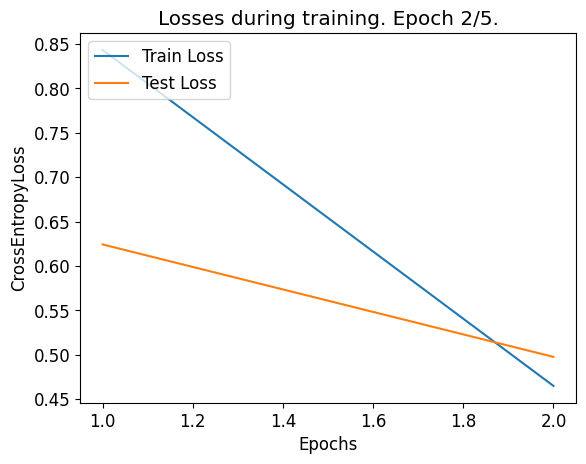

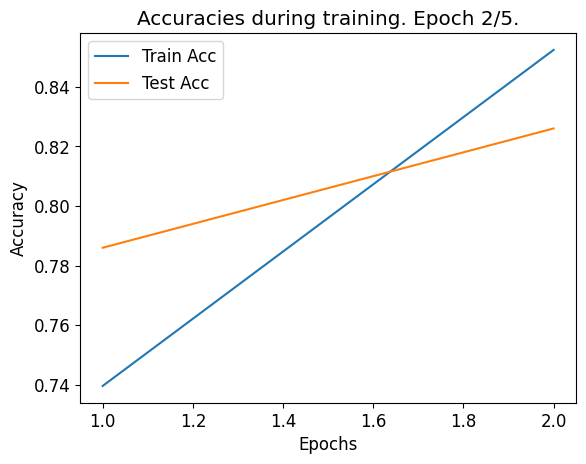

----------
Epoch Time: 0:08
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 35.99it/s, Loss=0.372153, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
train loss: 0.397214, acc: 0.873000, f05_macro: 0.869230, f1_macro: 0.869320
Confusion matrix:
[[269   0   0   4   1   3   5   2   1   0]
 [  0 329   2   1   1   1   0   0   5   0]
 [  1   2 251  10   4   8  14   3   6   0]
 [  5   0  13 215   0  38   4   4  15   1]
 [  2   3   1   0 300   1   6   3   1   8]
 [  2   1   9  37   1 205   4   5   8   2]
 [  4   4  10   2   3   1 280   0   1   1]
 [  4   1   9   0   2   1   0 297   1  14]
 [  0   7   2  15   1   8   1   4 219   4]
 [  3   0   0   3  12   1   0  11   3 254]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 49.75it/s, Loss=0.455313, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.429495, acc: 0.852000, f05_macro: 0.846043, f1_macro: 0.844003
Confusion matrix:
[[41  0  0  0  0  0  0  1  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 47  2  0  1  0  3  1  1]
 [ 0  1  1 27  0 13  1  2  0  0]
 [ 0  1  0  0 53  0  1  0  0  0]
 [ 0  2  2  6  0 30  1  5  4  0]
 [ 2  0  0  0  1  1 38  0  1  0]
 [ 0  0  0  0  1  0  0 45  0  3]
 [ 0  1  0  1  1  0  1  4 32  0]
 [ 0  1  0  0  2  2  0  2  1 46]]


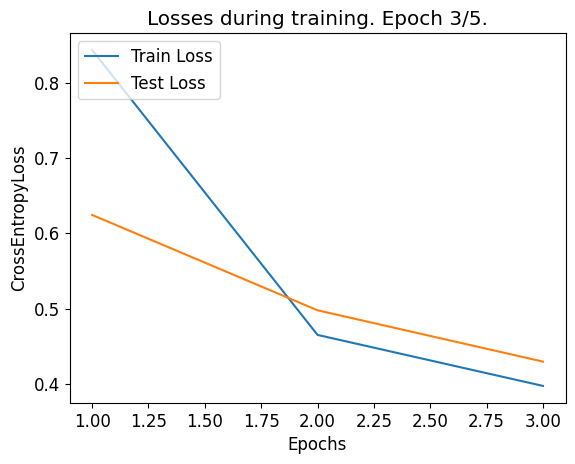

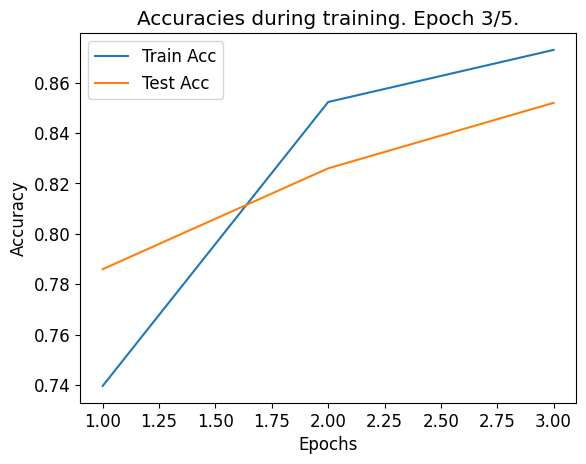

----------
Epoch Time: 0:05
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 35.48it/s, Loss=0.300989, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 0.365072, acc: 0.883000, f05_macro: 0.879471, f1_macro: 0.879566
Confusion matrix:
[[274   0   1   1   1   1   4   2   1   0]
 [  0 328   2   1   1   1   1   0   5   0]
 [  2   4 264  10   3   5   5   3   3   0]
 [  3   3  10 215   0  42   3   3  13   3]
 [  1   3   1   0 303   0   2   2   0  13]
 [  1   0   7  42   1 206   4   3   7   3]
 [  2   1   6   0   0   5 291   0   0   1]
 [  2   2   5   0   5   2   0 294   2  17]
 [  1   5   4  20   0   5   0   2 222   2]
 [  4   0   1   1   6   2   0  17   4 252]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 35.31it/s, Loss=0.397788, Corrects=15/20, Accuracy=75.000%]


Calculating metrics...
test loss: 0.414340, acc: 0.858000, f05_macro: 0.852237, f1_macro: 0.849999
Confusion matrix:
[[41  0  0  0  0  0  1  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 46  2  0  1  0  3  1  2]
 [ 0  1  0 36  0  6  0  2  0  0]
 [ 0  1  0  0 54  0  0  0  0  0]
 [ 1  0  1  9  0 28  2  5  3  1]
 [ 2  0  1  0  1  1 38  0  0  0]
 [ 0  0  1  0  1  0  0 44  0  3]
 [ 1  1  0  2  1  0  0  4 30  1]
 [ 0  1  0  0  4  1  0  2  1 45]]


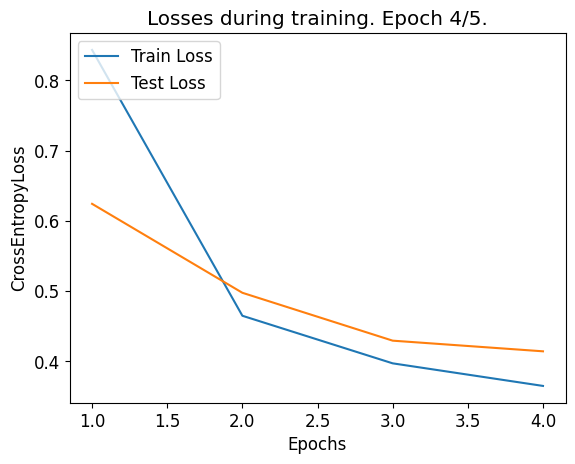

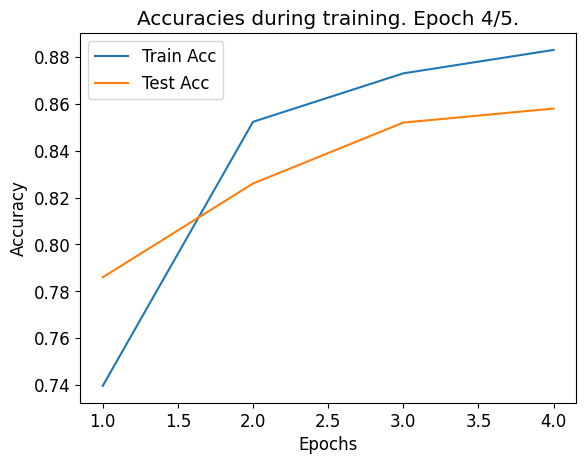

----------
Epoch Time: 0:06
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:05<00:00, 26.68it/s, Loss=0.139123, Corrects=19/20, Accuracy=95.000%]


Calculating metrics...
train loss: 0.337021, acc: 0.892667, f05_macro: 0.889856, f1_macro: 0.889595
Confusion matrix:
[[277   0   0   0   0   2   3   0   3   0]
 [  0 333   1   1   1   1   1   0   1   0]
 [  0   4 256  13   3   6   7   4   6   0]
 [  4   1   9 234   1  30   1   3  11   1]
 [  1   2   1   0 307   0   2   2   1   9]
 [  1   1   5  40   1 211   4   4   4   3]
 [  5   1   6   1   2   3 288   0   0   0]
 [  2   1   6   0   2   1   0 296   1  20]
 [  2   6   3  12   0   9   0   4 222   3]
 [  4   1   0   5   6   0   1  15   1 254]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 37.96it/s, Loss=0.383268, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
test loss: 0.428267, acc: 0.868000, f05_macro: 0.860007, f1_macro: 0.854464
Confusion matrix:
[[42  0  0  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 51  0  0  0  0  1  1  1]
 [ 0  0  2 21  0 18  1  1  2  0]
 [ 0  0  0  0 55  0  0  0  0  0]
 [ 0  0  1  2  0 37  2  6  1  1]
 [ 1  0  1  0  1  1 39  0  0  0]
 [ 0  0  0  0  0  0  0 46  0  3]
 [ 0  1  2  1  1  0  1  4 28  2]
 [ 0  1  0  0  2  1  0  1  1 48]]


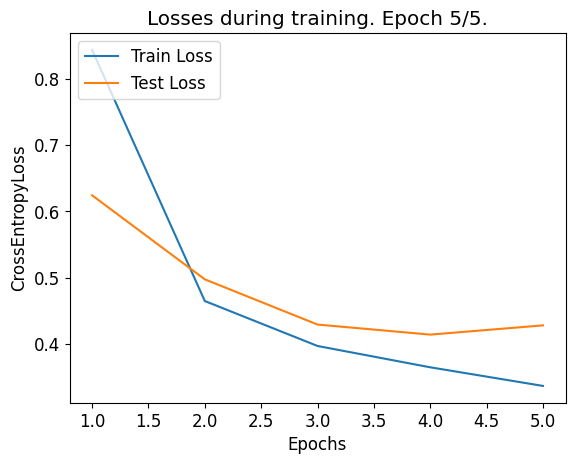

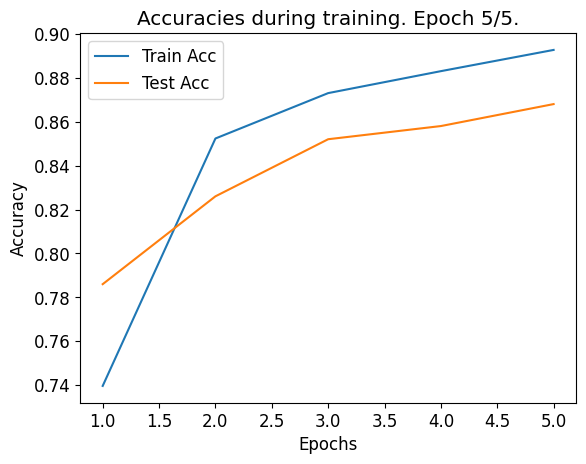

----------
Epoch Time: 0:07
*** Training Completed ***
Training model with  Swish  Activation function:
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:05<00:00, 28.25it/s, Loss=0.504380, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 1.147131, acc: 0.649000, f05_macro: 0.640703, f1_macro: 0.639196
Confusion matrix:
[[211   1  15  14  10   4  13   2  14   1]
 [  2 292   5   4  13   3   1   1  17   1]
 [ 19   9 169  34  14   9  23   8   9   5]
 [ 14  10  23 152   9  41   9   4  19  14]
 [ 14   7  11   8 232   0   4  13   5  31]
 [ 11   4  16  71  16 106  13  10  26   1]
 [ 24   7  13   8  10   5 233   0   5   1]
 [  6  10   4   7  18   2   5 237   7  33]
 [ 12  19  12  27   8  12   6   7 150   8]
 [ 11  11   4   8  39   1   6  34   8 165]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 42.07it/s, Loss=1.445991, Corrects=10/20, Accuracy=50.000%]


Calculating metrics...
test loss: 1.208132, acc: 0.578000, f05_macro: 0.566198, f1_macro: 0.535946
Confusion matrix:
[[33  0  0  0  0  0  1  0  0  8]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 7  4 23  5  0  0  9  0  3  4]
 [ 1 11  1 23  4  0  1  0  1  3]
 [ 1  1  0  0 36  0  4  0  0 13]
 [ 2  9  0 15  9  7  1  4  3  0]
 [ 4  4  1  0  3  1 30  0  0  0]
 [ 1  4  0  0  6  0  0 16  0 22]
 [ 0  4  1  2  5  0  2  1  8 17]
 [ 0  4  0  0  2  0  0  0  2 46]]
----------
Epoch Time: 0:05
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 38.65it/s, Loss=0.712388, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
train loss: 0.574843, acc: 0.829667, f05_macro: 0.824367, f1_macro: 0.824299
Confusion matrix:
[[262   0   1   1   1   2   9   0   8   1]
 [  0 325   1   0   2   0   2   1   8   0]
 [  1   6 233  18   7   4  14   5  10   1]
 [  0   4  23 193   1  35   6   3  20  10]
 [  3   5   1   0 295   0   2   2   0  17]
 [  4   2   5  49   1 190   4   6  11   2]
 [  6   6   4   4   4   6 275   0   1   0]
 [  5   4   2   0   9   5   0 280   2  22]
 [  3  13   4  19   1  14   1   2 196   8]
 [  7   1   1   2  13   2   1  17   3 240]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 43.32it/s, Loss=1.295640, Corrects=12/20, Accuracy=60.000%]


Calculating metrics...
test loss: 1.056679, acc: 0.658000, f05_macro: 0.646890, f1_macro: 0.628566
Confusion matrix:
[[33  0  0  0  1  0  1  0  0  7]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  1 31  1  0  0 12  0  5  4]
 [ 0  6  4 20  3  2  2  1  5  2]
 [ 1  1  0  0 44  0  3  0  0  6]
 [ 0  4  1 14  7  8  2  5  9  0]
 [ 1  0  1  0  3  0 38  0  0  0]
 [ 0  2  0  0  1  0  0 22  0 24]
 [ 0  1  1  1  6  0  2  0 21  8]
 [ 0  3  0  0  3  0  0  0  3 45]]


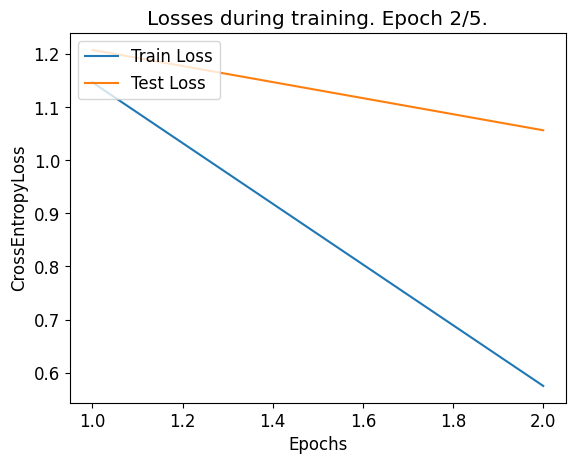

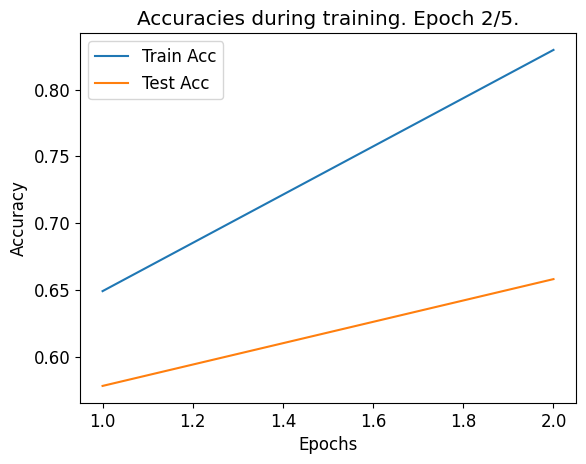

----------
Epoch Time: 0:05
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 36.14it/s, Loss=0.632968, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
train loss: 0.446210, acc: 0.864000, f05_macro: 0.860247, f1_macro: 0.860295
Confusion matrix:
[[264   0   3   1   1   1   6   0   7   2]
 [  0 326   1   0   1   1   2   1   7   0]
 [  0   1 242  13   4   6  14   6  10   3]
 [  3   3  15 218   0  31   6   5  11   3]
 [  2   2   2   0 304   0   2   1   1  11]
 [  4   2   4  42   1 205   4   3   9   0]
 [  6   7   5   3   4   5 276   0   0   0]
 [  3   1   3   2   6   2   0 288   1  23]
 [  3   8   7  11   1   4   1   4 218   4]
 [  5   0   0   2   7   5   1  15   1 251]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 38.65it/s, Loss=1.287954, Corrects=12/20, Accuracy=60.000%]


Calculating metrics...
test loss: 1.138546, acc: 0.640000, f05_macro: 0.612984, f1_macro: 0.601327
Confusion matrix:
[[37  0  0  0  2  0  0  0  0  3]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 3  5 35  0  0  0  5  0  3  4]
 [ 0 10  5 18  2  2  1  3  3  1]
 [ 1  1  0  0 48  0  1  0  0  4]
 [ 0  6  3 19  8  5  1  5  3  0]
 [ 2  3  1  0  4  0 33  0  0  0]
 [ 0  3  0  0  1  0  0 25  0 20]
 [ 1  5  1  1  9  0  2  2 13  6]
 [ 0  4  0  0  9  0  0  0  2 39]]


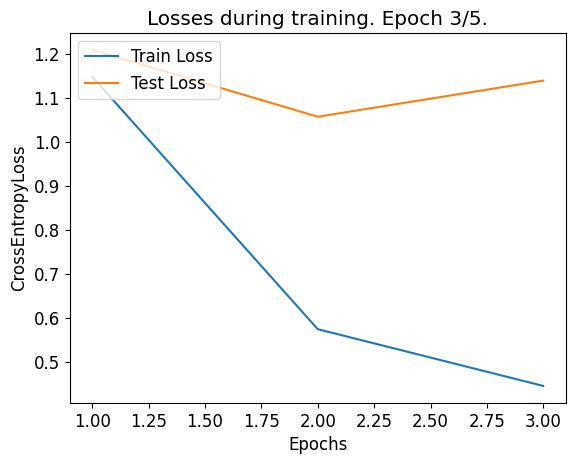

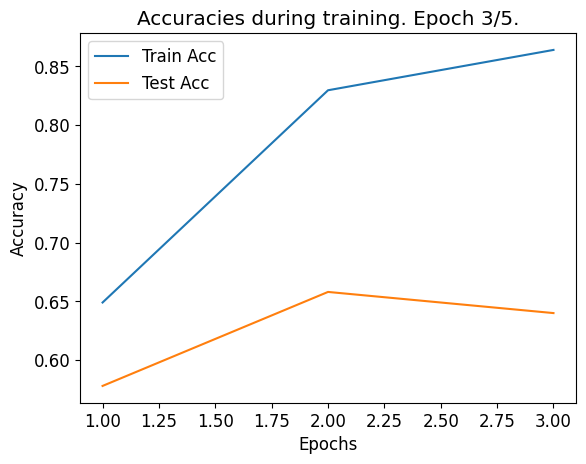

----------
Epoch Time: 0:06
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 31.39it/s, Loss=0.256370, Corrects=19/20, Accuracy=95.000%]


Calculating metrics...
train loss: 0.389883, acc: 0.881000, f05_macro: 0.877550, f1_macro: 0.877335
Confusion matrix:
[[274   0   1   0   0   1   4   1   2   2]
 [  1 324   3   0   0   0   1   2   8   0]
 [  1   6 253   8   3   6   9   2   8   3]
 [  1   1  12 219   0  35   4   5  13   5]
 [  4   1   0   0 313   0   3   0   0   4]
 [  0   1   5  53   2 201   4   4   2   2]
 [  5   5   5   3   2   3 283   0   0   0]
 [  1   1   2   1   5   1   0 300   1  17]
 [  0   9   4  15   1   7   0   2 218   5]
 [  1   0   1   4   6   1   1  12   3 258]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 39.72it/s, Loss=1.433627, Corrects=12/20, Accuracy=60.000%]


Calculating metrics...
test loss: 1.100684, acc: 0.672000, f05_macro: 0.636069, f1_macro: 0.634107
Confusion matrix:
[[38  0  0  0  2  0  0  1  0  1]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 3  1 38  0  0  0  6  1  3  3]
 [ 0  6  4 19  4  2  3  2  4  1]
 [ 1  1  0  0 48  0  3  0  0  2]
 [ 0  5  1 21  8  4  3  4  4  0]
 [ 1  0  1  0  3  0 38  0  0  0]
 [ 0  2  0  0  1  0  0 30  0 16]
 [ 1  2  1  1  8  0  2  4 19  2]
 [ 0  4  0  0 11  0  0  0  4 35]]


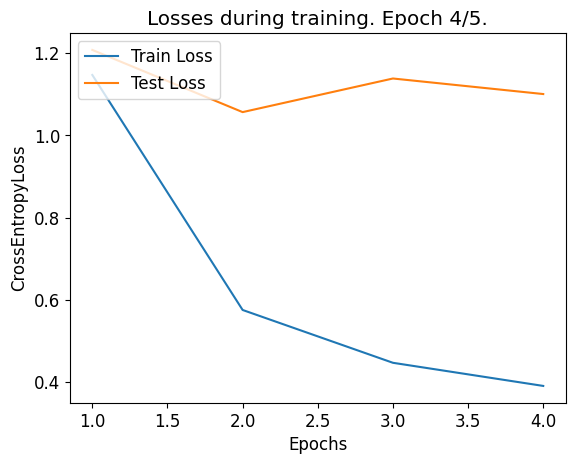

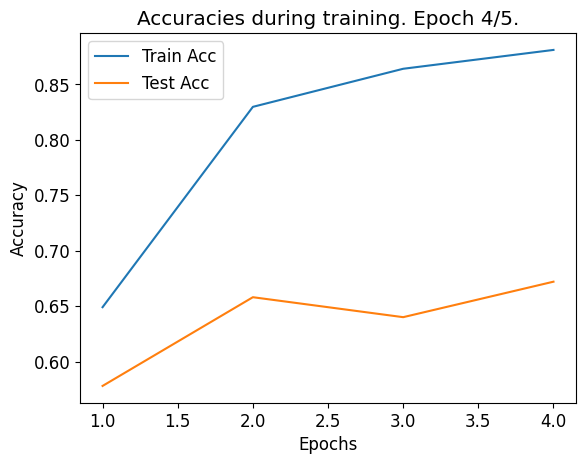

----------
Epoch Time: 0:06
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 30.42it/s, Loss=0.328668, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
train loss: 0.352606, acc: 0.897667, f05_macro: 0.894510, f1_macro: 0.894254
Confusion matrix:
[[275   0   0   1   1   0   5   1   2   0]
 [  0 331   1   0   0   0   1   0   6   0]
 [  1   1 258  14   5   5   9   1   4   1]
 [  4   1   9 233   0  28   3   7   7   3]
 [  3   2   1   0 306   0   1   2   3   7]
 [  2   1   5  38   2 211   5   4   4   2]
 [  4   2   3   2   1   1 293   0   0   0]
 [  1   0   4   1   2   2   1 304   2  12]
 [  2   4   5  13   2   6   1   6 219   3]
 [  3   0   2   2   5   1   0   7   4 263]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 36.22it/s, Loss=1.565138, Corrects=11/20, Accuracy=55.000%]


Calculating metrics...
test loss: 1.314861, acc: 0.628000, f05_macro: 0.599430, f1_macro: 0.581661
Confusion matrix:
[[28  0  0  0  6  0  4  2  0  2]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 2  2 31  0  0  0  7  1  9  3]
 [ 0 10  5  5  4  2  2  4 13  0]
 [ 1  1  0  0 48  0  3  0  0  2]
 [ 0  8  3  2  7  7  2  6 14  1]
 [ 1  1  1  0  2  0 38  0  0  0]
 [ 0  2  0  0  5  0  0 30  1 11]
 [ 0  2  0  0  7  0  2  2 25  2]
 [ 0  5  0  0 10  0  0  0  4 35]]


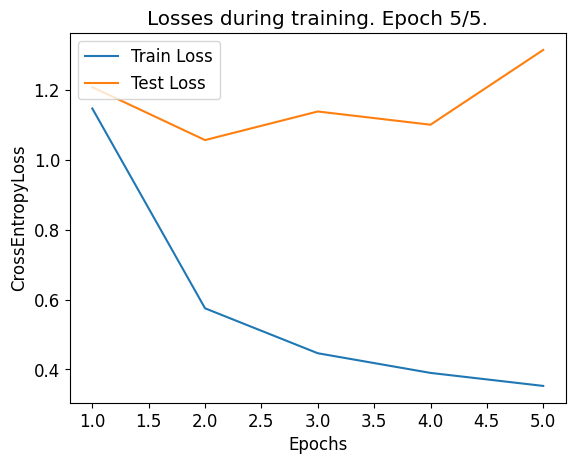

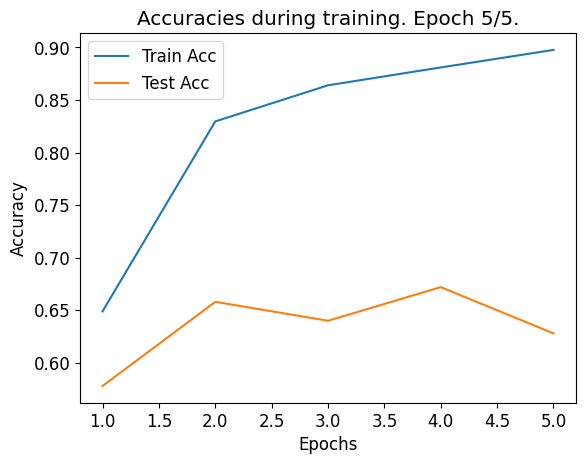

----------
Epoch Time: 0:06
*** Training Completed ***
Training model with  SoftPlus  Activation function:
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 36.84it/s, Loss=0.364924, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 1.149482, acc: 0.630333, f05_macro: 0.621244, f1_macro: 0.620505
Confusion matrix:
[[210   3  13  17  10   9  13   5   2   3]
 [  7 276   3   4   1   3   6   6  19  14]
 [ 12  11 176  24  16   5  24  14   9   8]
 [ 14  10  17 151   3  51   3   5  27  14]
 [  4   6   4   6 220   5   9  10   1  60]
 [ 20  15  15  55   9  94  11  25  18  12]
 [ 18  11  20   4  12   8 222   2   1   8]
 [ 16  12   7   2  13   4   3 235   3  34]
 [  7  32   5  30   5  13   5   9 141  14]
 [ 11   6   5   6  52   5   1  25  10 166]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 45.87it/s, Loss=0.820219, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
test loss: 0.656422, acc: 0.790000, f05_macro: 0.774306, f1_macro: 0.771528
Confusion matrix:
[[41  0  0  1  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 46  3  0  0  3  0  3  0]
 [ 1  0  4 31  0  5  2  0  2  0]
 [ 1  0  0  0 51  0  0  1  1  1]
 [ 1  1  2 18  1 15  1  6  5  0]
 [ 2  0  3  1  1  1 35  0  0  0]
 [ 0  2  0  2  1  1  0 32  1 10]
 [ 0  1  1  5  0  0  1  2 29  1]
 [ 0  1  0  1  1  0  0  0  3 48]]
----------
Epoch Time: 0:04
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 36.96it/s, Loss=0.432706, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
train loss: 0.562818, acc: 0.826000, f05_macro: 0.820934, f1_macro: 0.820732
Confusion matrix:
[[262   0   3   3   1   8   4   1   3   0]
 [  0 324   2   2   1   2   1   0   7   0]
 [  1   3 236  18   9   4  15   7   5   1]
 [  5   2  21 193   1  47   3   3  16   4]
 [  3   4   1   0 289   1   7   3   2  15]
 [  3   2  10  46   1 179  10   6  15   2]
 [  4   3  14   3   4   6 270   1   1   0]
 [  1   4   2   0   7   4   0 291   3  17]
 [  1  12   6  31   0   8   3   5 192   3]
 [  4   2   2   4  13   2   1  14   3 242]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 35.88it/s, Loss=0.598532, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.590893, acc: 0.794000, f05_macro: 0.789639, f1_macro: 0.783681
Confusion matrix:
[[42  0  0  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 34  5  0  1  6  2  6  1]
 [ 0  0  0 28  0  9  0  0  7  1]
 [ 0  0  0  0 51  0  0  0  3  1]
 [ 0  1  1  8  0 21  1  5 13  0]
 [ 1  0  1  0  1  3 36  0  1  0]
 [ 0  0  1  0  0  0  0 38  3  7]
 [ 0  0  1  2  0  0  1  3 32  1]
 [ 0  1  0  0  0  0  0  0  5 48]]


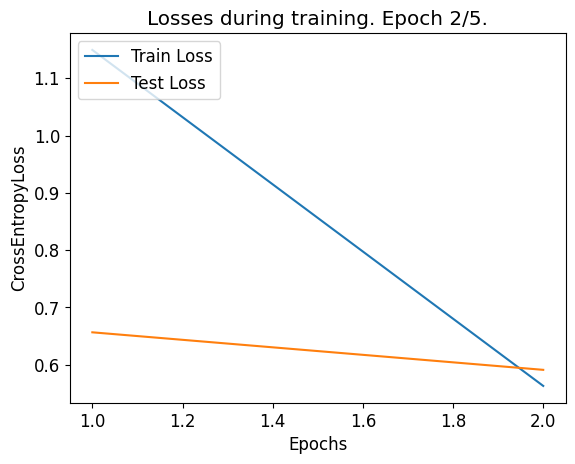

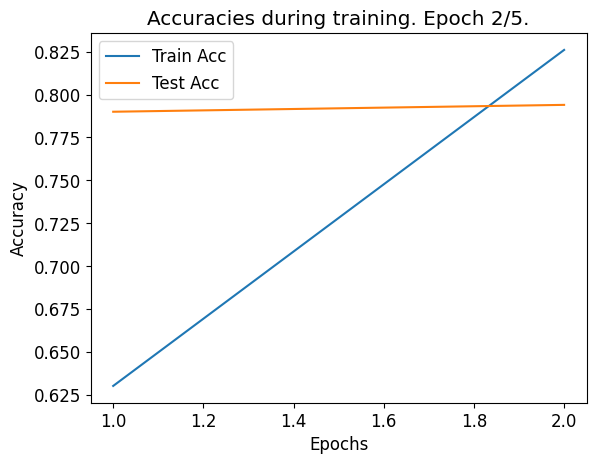

----------
Epoch Time: 0:06
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 32.22it/s, Loss=0.350283, Corrects=19/20, Accuracy=95.000%]


Calculating metrics...
train loss: 0.486387, acc: 0.849000, f05_macro: 0.844530, f1_macro: 0.844257
Confusion matrix:
[[266   0   2   1   0   4   7   3   2   0]
 [  0 321   3   2   1   1   0   2   9   0]
 [  3   3 243  13   5   7  14   2   9   0]
 [  3   3  13 211   0  40   3   3  18   1]
 [  3   3   1   0 296   0   4   1   2  15]
 [  4   0   2  42   2 194  10   5  11   4]
 [  2   7   7   3   4   4 277   0   0   2]
 [  1   2   7   0   2   2   0 298   0  17]
 [  1  15   5  25   1   7   2   3 195   7]
 [  4   1   0   5  10   1   2  15   3 246]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 36.53it/s, Loss=0.529358, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.530862, acc: 0.842000, f05_macro: 0.834130, f1_macro: 0.826546
Confusion matrix:
[[42  0  0  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 49  2  0  0  1  1  1  0]
 [ 1  0  1 40  0  3  0  0  0  0]
 [ 1  0  0  0 52  0  1  0  1  0]
 [ 0  0  2 21  0 17  1  6  3  0]
 [ 2  0  1  0  0  1 39  0  0  0]
 [ 0  0  1  1  0  0  0 45  0  2]
 [ 0  1  2  3  0  0  1  5 27  1]
 [ 0  0  0  3  2  0  0  5  1 43]]


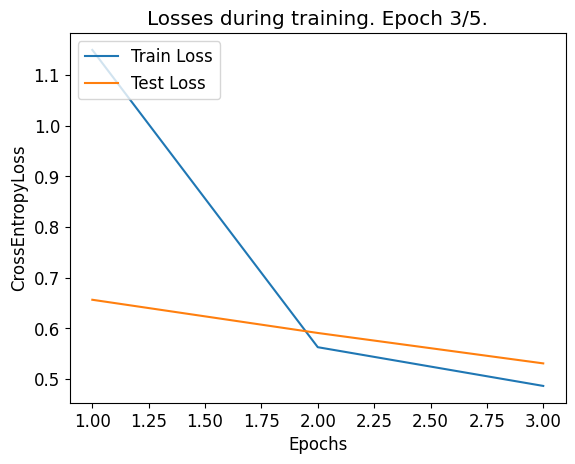

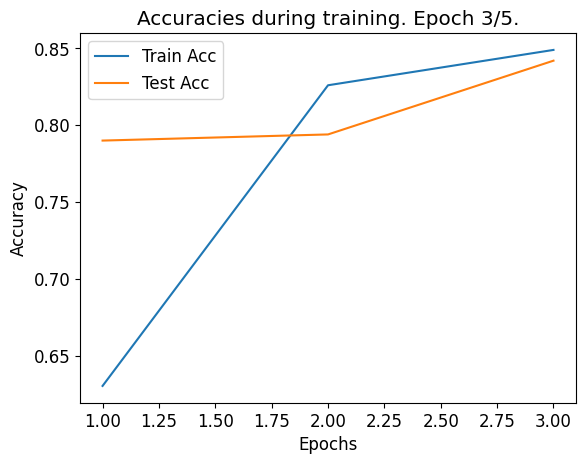

----------
Epoch Time: 0:06
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 31.97it/s, Loss=0.451530, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 0.434998, acc: 0.859667, f05_macro: 0.855966, f1_macro: 0.855757
Confusion matrix:
[[268   0   3   3   3   0   4   3   1   0]
 [  0 327   1   1   0   2   2   1   5   0]
 [  0   5 250   8   5  10  11   5   5   0]
 [  5   2  13 213   0  39   2   4  16   1]
 [  2   2   6   0 298   0   1   1   4  11]
 [  1   2   3  48   1 197   4   6  12   0]
 [  2   4   6   0   3   8 282   0   1   0]
 [  4   1   4   1   7   2   0 290   0  20]
 [  1  13   4  22   0   8   0   1 207   5]
 [  3   0   1   3   9   3   1  18   2 247]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 38.45it/s, Loss=0.497660, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.458745, acc: 0.856000, f05_macro: 0.844673, f1_macro: 0.844397
Confusion matrix:
[[42  0  0  0  0  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 51  0  0  0  0  1  1  1]
 [ 0  0  2 31  0  9  0  1  2  0]
 [ 0  0  0  0 46  0  1  1  2  5]
 [ 1  0  2 11  0 23  1  5  7  0]
 [ 2  0  0  0  0  1 40  0  0  0]
 [ 0  0  1  0  0  0  0 44  1  3]
 [ 1  0  1  1  0  0  0  3 34  0]
 [ 0  0  0  0  0  0  0  1  3 50]]


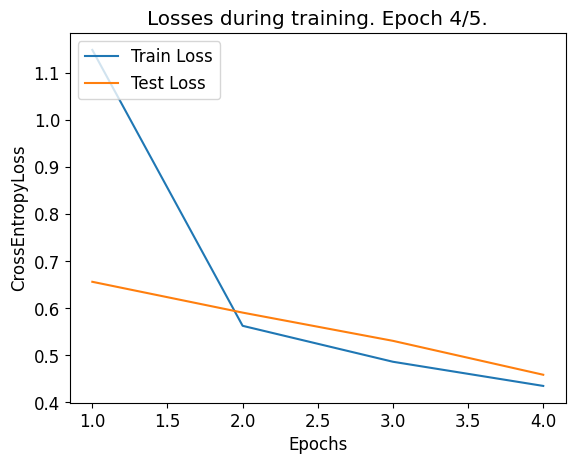

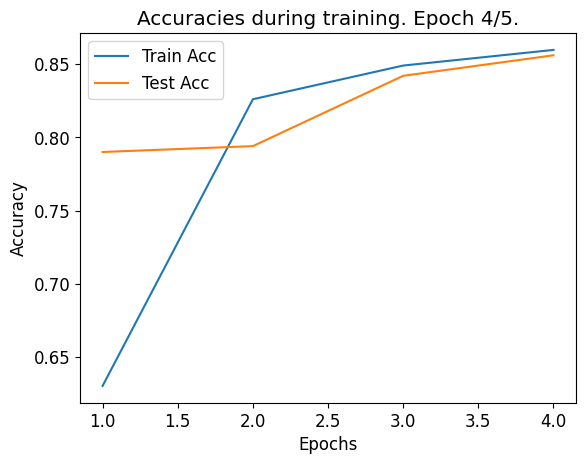

----------
Epoch Time: 0:06
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:04<00:00, 31.32it/s, Loss=0.125800, Corrects=19/20, Accuracy=95.000%]


Calculating metrics...
train loss: 0.403084, acc: 0.874667, f05_macro: 0.871288, f1_macro: 0.870992
Confusion matrix:
[[274   0   0   2   0   2   6   1   0   0]
 [  0 325   2   1   1   1   0   1   8   0]
 [  1   3 261  11   2   4   8   4   4   1]
 [  4   2   5 216   0  40   3   5  17   3]
 [  0   1   0   0 310   0   2   3   3   6]
 [  1   1   7  48   0 198   5   3   6   5]
 [  1   1   4   3   4   7 285   1   0   0]
 [  1   1   6   1   4   3   0 293   0  20]
 [  0   7   3  25   1   6   1   1 212   5]
 [  5   0   1   2   5   2   0  19   3 250]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 39.87it/s, Loss=0.646222, Corrects=15/20, Accuracy=75.000%]


Calculating metrics...
test loss: 0.489106, acc: 0.838000, f05_macro: 0.829020, f1_macro: 0.826987
Confusion matrix:
[[39  0  0  0  0  0  1  0  0  2]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 49  0  0  0  2  1  1  1]
 [ 0  0  1 35  0  6  0  0  3  0]
 [ 0  0  0  0 47  0  2  0  1  5]
 [ 0  0  1 15  0 22  1  5  5  1]
 [ 2  0  1  0  0  1 39  0  0  0]
 [ 0  0  2  1  0  0  0 40  0  6]
 [ 0  0  1  2  0  0  1  2 33  1]
 [ 0  0  0  1  1  0  0  1  3 48]]


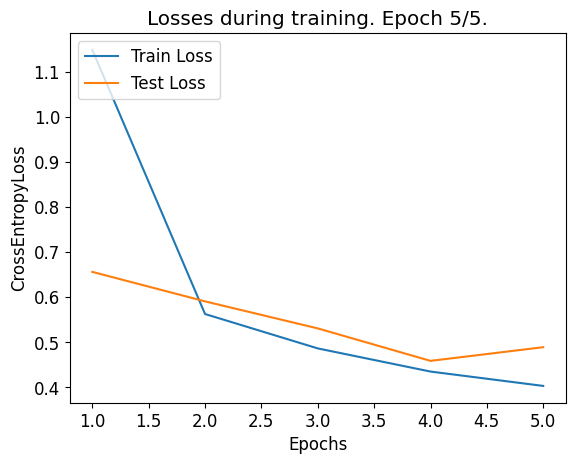

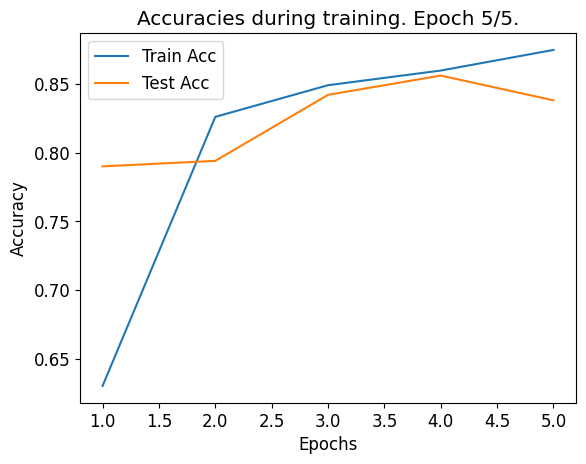

----------
Epoch Time: 0:06
*** Training Completed ***


In [ ]:
from torch import optim
import pytorch_optimizer

activation_functions_dict = {
    'ReLU': ReLU_imp,
    'Tanh': Tanh_imp,
    'GELU': GELU_imp,
    'Swish': Swish_imp,
    'SoftPlus': SoftPlus_imp
}
num_epochs = 5
learning_rate = (1e-3)
criterion = nn.CrossEntropyLoss()
results = []
for x in activation_functions_dict.keys():
  model = Net(num_classes, activation_functions_dict[x]).to(device)
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  print('Training model with ', x, ' Activation function:')

  saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros \
  = train_model(dataloaders, num_epochs)
  results.append((x, [saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros]))

5 5


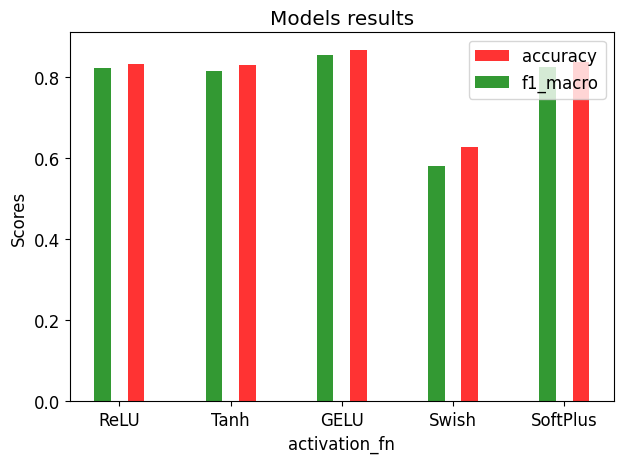

In [ ]:
# data to plot
# loss = []
max_acc = 0
best_act = ''
accuracy = []
f1_macro = []
i = 0
for x in results:
  # loss.append(x[1][0]['test'][-1])
  accuracy.append(x[1][1]['test'][-1])
  if accuracy[-1]> max_acc:
    max_acc = accuracy[-1]
    best_act = x[0]
  f1_macro.append(x[1][2]['test'][-1])
  i = i + 1

print( len(accuracy), len(f1_macro))
# create plot
fig, ax = plt.subplots()
index = np.arange(len(activation_functions_dict))
bar_width = 0.3
opacity = 0.8

# rects1 = plt.bar(index, loss, bar_width/2,
# alpha=opacity,
# color='b',
# label='loss')
rects2 = plt.bar(index+bar_width/2, accuracy, bar_width/2,
alpha=opacity,
color='r',
label='accuracy')
rects3 = plt.bar(index-bar_width/2, f1_macro, bar_width/2,
alpha=opacity,
color='g',
label='f1_macro')

plt.xlabel('activation_fn')
plt.ylabel('Scores')
plt.title('Models results')
plt.xticks(index, activation_functions_dict.keys())
plt.legend()

plt.tight_layout()
plt.show()

#Plot the accuracy activation functions against epochs

In [ ]:
print('best accuracy is ', max_acc, ' by ', best_act)

best accuracy is  0.868  by  GELU


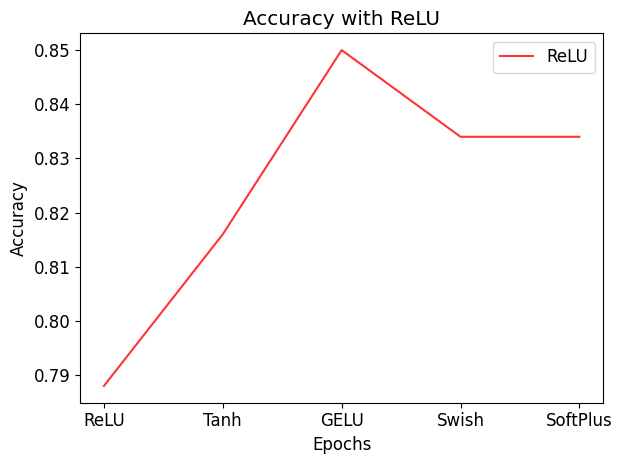

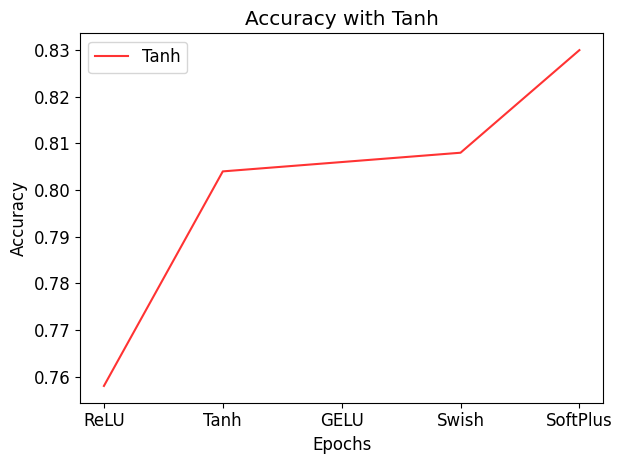

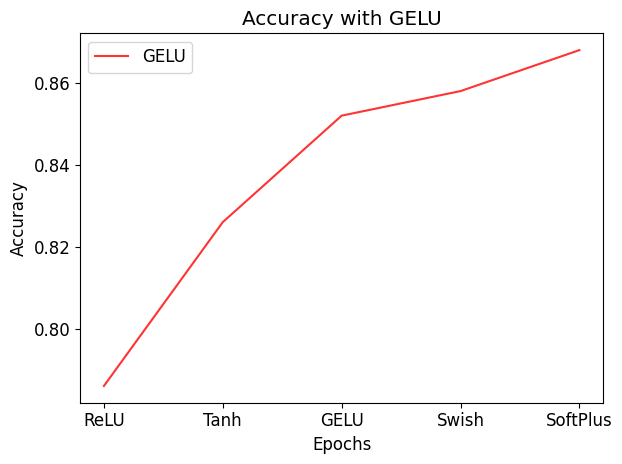

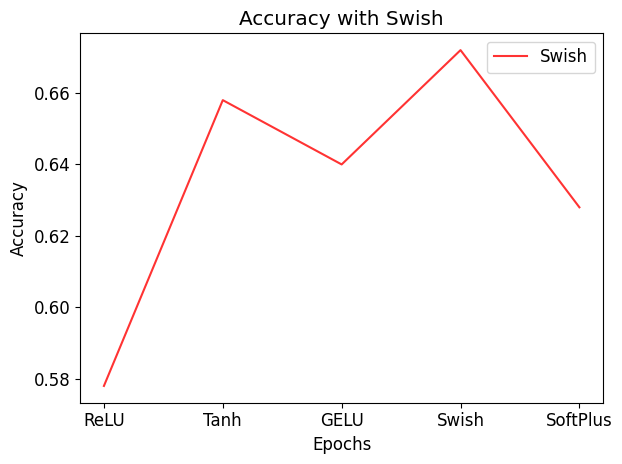

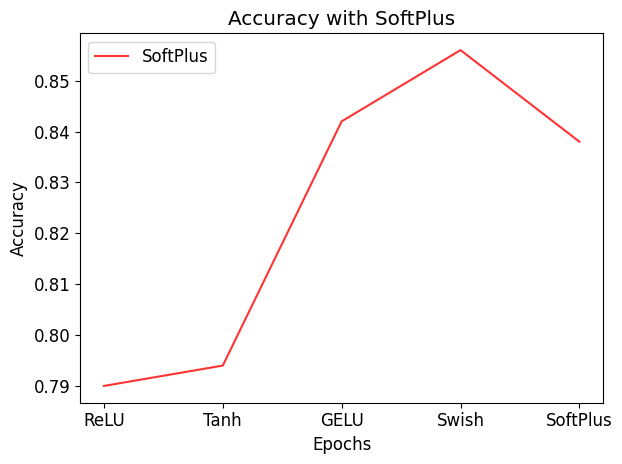

In [ ]:
for x in results:
  fig, ax = plt.subplots()
  index = np.arange(len(x[1][1]['test']))
  opacity = 0.8
  # print(x[1][1]['test'])
  rects2 = plt.plot(index, x[1][1]['test'],
  alpha=opacity,
  color='r',
  label=x[0])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy with ' + x[0])
  plt.xticks(index, activation_functions_dict.keys())
  plt.legend()

  plt.tight_layout()
  plt.show()

#Come up with a more effective activation function in this case.

after seeing the results of training on different activation functions we can notice that GELU and Tanh are the promising functions, so the better activation function can be obtained from them

In [ ]:
# 0.876
class GELU_Tanh_edit_imp(torch.nn.Module):
  def __init__(self):
      super(GELU_Tanh_edit_imp, self).__init__()
      return
  def forward(self, x):
      return (torch.tanh(torch.max(tensor(2),x)))*x**2*0.4

Training model with   Activation function:
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 43.02it/s, Loss=0.608844, Corrects=15/20, Accuracy=75.000%]


Calculating metrics...
train loss: 1.110173, acc: 0.626667, f05_macro: 0.621291, f1_macro: 0.619892
Confusion matrix:
[[208   3  10   7  10  10  14   3   6  14]
 [  2 287   6   2  10   3   2   3  20   4]
 [ 25  13 163  37   9  10  12  10  14   6]
 [ 17  12  29 136   4  37   5   8  35  12]
 [ 14  18  12   4 218   7   7   8   6  31]
 [ 17   8  12  56   9 121   8   7  27   9]
 [ 19  12   5  11  13   9 221   0   8   8]
 [  8   9   5   5  22   3   2 192  15  68]
 [  8  16  14  20   2  17   1  12 153  18]
 [  7   7  11   8  19   7   0  42   5 181]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 53.64it/s, Loss=0.731103, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
test loss: 0.648106, acc: 0.810000, f05_macro: 0.793511, f1_macro: 0.787415
Confusion matrix:
[[39  0  0  0  0  2  0  0  0  1]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 2  0 45  1  0  1  1  3  1  1]
 [ 0  1  4  8  0 29  0  1  1  1]
 [ 0  1  0  0 52  0  1  0  0  1]
 [ 0  1  2  2  2 38  2  2  1  0]
 [ 2  0  2  0  1  3 35  0  0  0]
 [ 0  0  0  0  1  2  0 40  1  5]
 [ 0  0  1  1  0  3  1  1 33  0]
 [ 0  0  0  0  0  0  0  3  3 48]]
----------
Epoch Time: 0:04
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 39.44it/s, Loss=0.746015, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
train loss: 0.494629, acc: 0.842667, f05_macro: 0.837727, f1_macro: 0.837873
Confusion matrix:
[[263   0   2   2   2   5   8   0   1   2]
 [  0 322   3   3   1   0   0   3   7   0]
 [  0   4 238  18   4   7   8   4  13   3]
 [  2   1  11 206   0  47   4   4  19   1]
 [  2   3   3   0 300   2   2   2   0  11]
 [  8   1   7  42   2 188   5   6  13   2]
 [  4   3   5   2   7   5 280   0   0   0]
 [  4   3   5   0   9   0   0 281   1  26]
 [  2   7  12  16   1   9   1   1 202  10]
 [  2   0   3   3   4   0   0  22   5 248]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 34.49it/s, Loss=0.620258, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.543850, acc: 0.826000, f05_macro: 0.816815, f1_macro: 0.815881
Confusion matrix:
[[39  0  0  0  2  0  0  0  0  1]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  0 34  9  0  2  4  4  2  0]
 [ 0  1  2 29  0  7  2  2  2  0]
 [ 0  0  0  0 53  0  1  1  0  0]
 [ 0  0  0  8  0 27  1  3  9  2]
 [ 1  0  1  0  0  2 39  0  0  0]
 [ 0  0  0  0  1  1  0 44  1  2]
 [ 1  0  1  2  0  1  0  0 35  0]
 [ 0  0  0  0  4  0  0  1  3 46]]


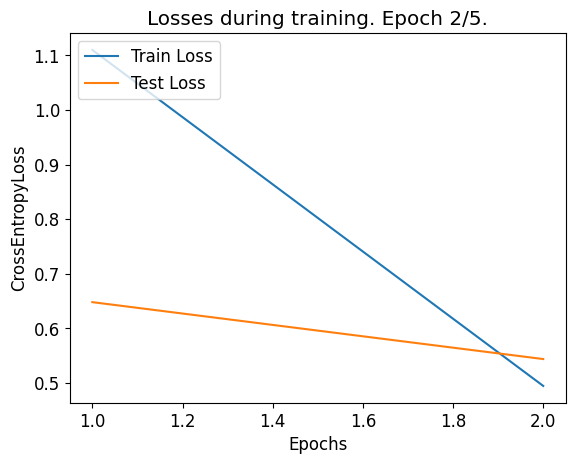

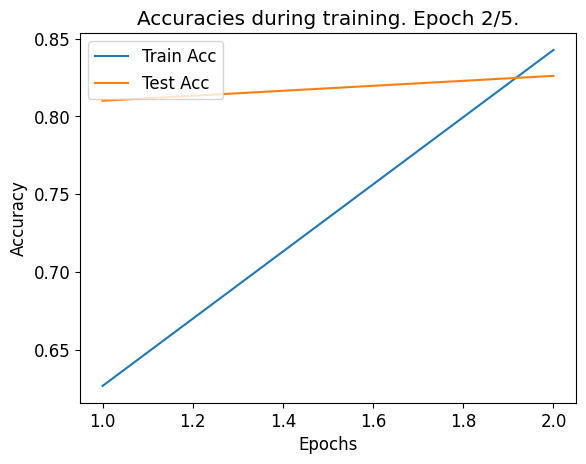

----------
Epoch Time: 0:05
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:05<00:00, 29.10it/s, Loss=0.256418, Corrects=18/20, Accuracy=90.000%]


Calculating metrics...
train loss: 0.415050, acc: 0.862000, f05_macro: 0.858756, f1_macro: 0.858711
Confusion matrix:
[[267   0   1   1   1   5   7   1   1   1]
 [  0 327   3   0   0   1   1   1   6   0]
 [  0   4 245  15   5   7   8   3  11   1]
 [  3   1  13 214   0  45   1   7  10   1]
 [  2   1   4   0 299   2   1   3   1  12]
 [  1   3   4  41   0 203   5   9   7   1]
 [  5   3   3   3   2   7 283   0   0   0]
 [  4   2   4   1   7   3   0 286   1  21]
 [  2   4  13   9   0   4   0   4 221   4]
 [  5   0   1   2   6   2   1  26   3 241]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 33.90it/s, Loss=0.647824, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.497847, acc: 0.836000, f05_macro: 0.834478, f1_macro: 0.830027
Confusion matrix:
[[39  0  0  0  3  0  0  0  0  0]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 0  3 39  4  0  1  1  2  1  4]
 [ 1  1  1 32  1  6  0  2  1  0]
 [ 0  0  0  0 54  0  0  1  0  0]
 [ 1  1  0 11  0 29  2  3  2  1]
 [ 1  0  1  0  4  1 36  0  0  0]
 [ 0  0  0  0  2  1  0 42  0  4]
 [ 0  0  2  2  3  0  0  0 33  0]
 [ 0  0  0  0  5  0  0  2  0 47]]


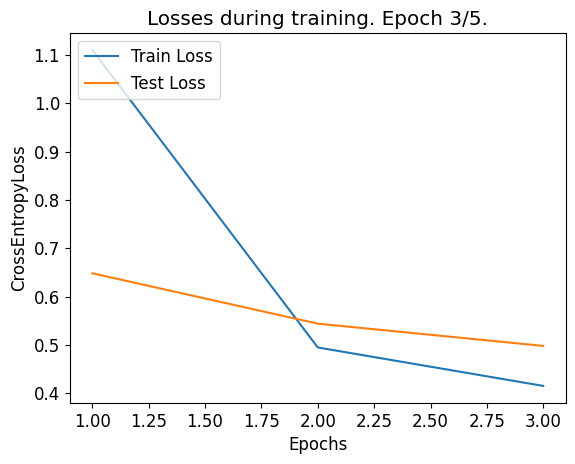

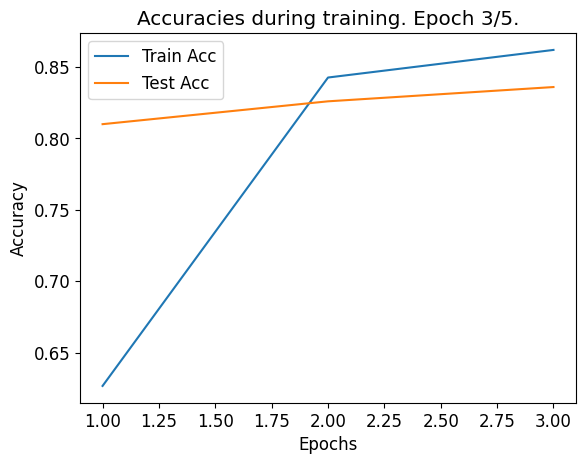

----------
Epoch Time: 0:06
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 40.47it/s, Loss=0.785860, Corrects=15/20, Accuracy=75.000%]


Calculating metrics...
train loss: 0.352521, acc: 0.888333, f05_macro: 0.885336, f1_macro: 0.885425
Confusion matrix:
[[274   1   1   1   1   2   4   0   0   1]
 [  0 330   2   1   1   2   1   1   1   0]
 [  0   3 254  13   1   8   7   4   7   2]
 [  1   0  12 226   0  40   1   4  11   0]
 [  1   2   0   0 311   1   1   1   2   6]
 [  2   1   2  41   0 212   3   2   8   3]
 [  9   3   2   3   2   2 284   0   0   1]
 [  1   1   7   0   6   4   0 289   0  21]
 [  1   3   7   3   1  10   0   0 231   5]
 [  2   0   0   0   6   2   1  18   4 254]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 48.23it/s, Loss=0.574373, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
test loss: 0.477808, acc: 0.858000, f05_macro: 0.853575, f1_macro: 0.849277
Confusion matrix:
[[39  0  0  0  2  0  0  0  0  1]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 48  0  0  0  2  3  0  1]
 [ 0  1  5 30  0  4  2  2  1  0]
 [ 0  0  0  0 51  0  1  2  0  1]
 [ 1  1  3  9  0 27  2  6  1  0]
 [ 1  0  1  0  0  1 40  0  0  0]
 [ 0  0  0  0  0  0  0 47  0  2]
 [ 0  0  2  1  0  0  2  2 33  0]
 [ 0  1  0  0  0  0  0  5  1 47]]


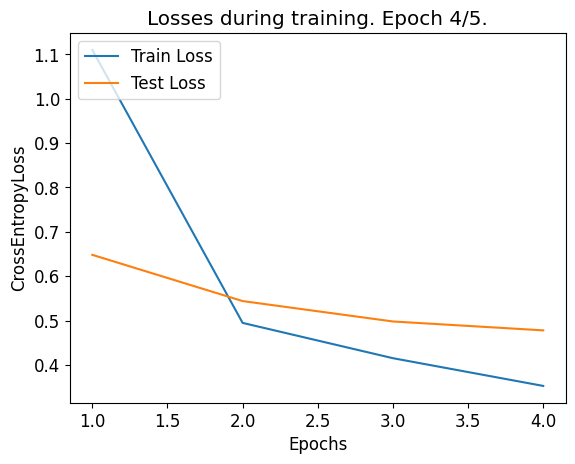

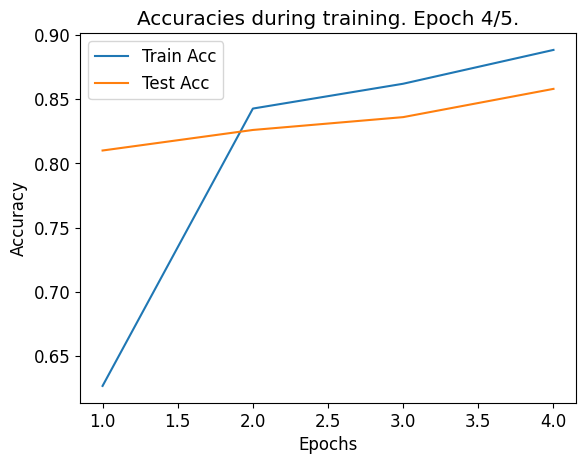

----------
Epoch Time: 0:05
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 150/150 [00:03<00:00, 39.95it/s, Loss=0.281649, Corrects=17/20, Accuracy=85.000%]


Calculating metrics...
train loss: 0.325031, acc: 0.892000, f05_macro: 0.888834, f1_macro: 0.888904
Confusion matrix:
[[277   0   1   0   0   3   1   0   1   2]
 [  0 327   2   1   3   0   2   0   4   0]
 [  2   3 263  12   2   2   6   3   6   0]
 [  2   1  11 227   0  35   2   4  12   1]
 [  1   1   1   0 309   0   3   5   1   4]
 [  3   0   3  41   1 208   3   4   8   3]
 [  2   3   5   2   3   3 287   0   0   1]
 [  1   2   2   1   6   2   1 296   1  17]
 [  3   2   8  11   0   5   0   0 227   5]
 [  2   0   0   2   5   3   0  17   3 255]]
--- Cur phase: test


100%|██████████| 25/25 [00:00<00:00, 46.25it/s, Loss=0.628123, Corrects=16/20, Accuracy=80.000%]


Calculating metrics...
test loss: 0.485300, acc: 0.846000, f05_macro: 0.842035, f1_macro: 0.838059
Confusion matrix:
[[38  0  0  0  1  0  0  0  0  3]
 [ 0 67  0  0  0  0  0  0  0  0]
 [ 1  0 45  4  0  0  2  2  0  1]
 [ 0  1  5 25  0 11  1  1  0  1]
 [ 0  0  0  0 51  0  1  1  0  2]
 [ 0  1  2  8  0 32  3  4  0  0]
 [ 1  0  0  0  0  1 41  0  0  0]
 [ 0  0  0  0  0  1  0 41  0  7]
 [ 0  0  1  3  0  0  2  0 31  3]
 [ 0  0  0  0  1  0  0  1  0 52]]


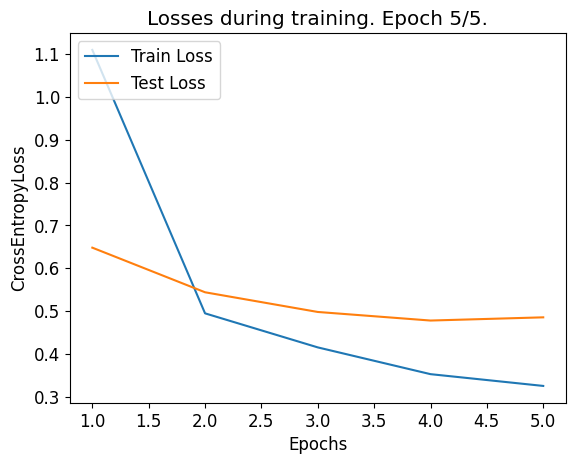

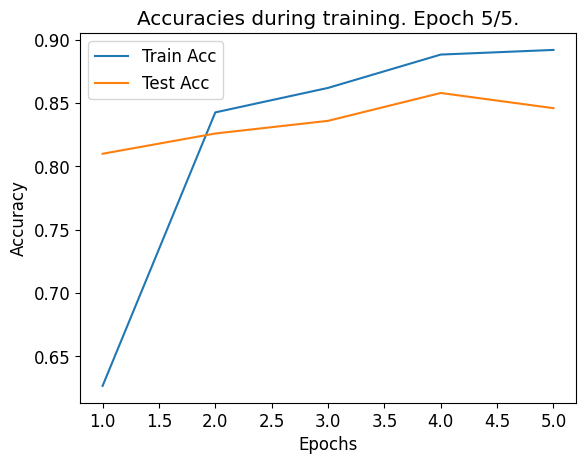

----------
Epoch Time: 0:05
*** Training Completed ***


In [ ]:
model = Net(num_classes, GELU_Tanh_edit_imp).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
print('Training model with ', ' Activation function:')

saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros \
= train_model(dataloaders, num_epochs)

In [ ]:
print('best accuracy by edited gelu is: ', np.asarray(saved_epoch_accuracies['test']).max())

best accuracy by edited gelu is:  0.858
